## Unsustainable water use

The water footprint is an indicator of direct and indirect appropriation of freshwater resources. This term includes both consumptive water use (the blue and green water footprint) and the water required to assimilate pollution (grey water footprint).

Advanced frameworks consider both water performance in the direct operation as well as the indirect water footprint in order to fully understand how a certain business relates to water use efficiency and the exposure to risk.

The indicator provides incentives to improve water use efficiency through all sectors, highlighting those sectors where water use efficiency is lagging behind. 

We derive the total amount of annual, crop-specific water use from the blue water requirements of the Water Footprint Network (WFN) data layer. All calculations are performed on the grid-cell level  which comes in a resolution 5 minutes by 5 minutes (~10 km by 10 km).

Unsustainable water consumption (m3 / year) = blue water footprint (mm / yr) * harvest area portion in that location * tonnes (Tonne)  * 10000/1000 * yield (ha/Tonne)


Potential datasets:

- Global water footprint by crop (1996 -2005) from Water Footprint which is splited by:
    - Blue Footprint by crop
    - Green Footprint by crop
    - Grey Footprint by crop
    - Total Footprint by crop
    
    Link to dataset: "https://waterfootprint.org/media/downloads/Report47-App-IV-CropWaterFootprints-RasterMaps.zip"
    
- BWS from aqueduct: https://www.wri.org/data/aqueduct-global-maps-30-data
- Harvested area and yield for 175 crops: http://www.earthstat.org/harvested-area-yield-175-crops/

### Insights from notebook and generalizations:

The first part of the notebook covers the generation of the water risk map. This water risk map is calculated for each commodity (in this case cotton) and following the formula below (which is also presented in this doc: https://docs.google.com/document/d/1h4BIWMrv6OGRAgNPlOfjOLex_FHb9h22RRTLp00QMzs/edit#

        Water risk  (m3 / year ) =  blue water footprint (mm / yr) * harvest area portion in that location  * 1/1000(unit conversion)

This calculation has been done with gdal and has to be generalised to the different commodities.

The second part of the notebook explores the generation of the potential distributed purchase area (which sould be updated as it's highlighted in the notebook 0_5_Area_distribution. This calculations have been also done with gdal for the time being.

Finally we calculate the water metric by multiplying the water risk map and the potential distributed purchase area, following the formula: 

        Unsustainable water consumption (m3 / year) = risk map (m3/year*hectare) * probability purchase area (unitless) 
        
 NOTE: Both the water risk map and the potential distributed purchase area will need to be translater to h3. The final calculation (the calculation of the metric) would be done by combining the indexes of both h3 layers.


## Table of Contents
- ### [1. Import libraries](#libraries)
- ### [2. Calculation of water risk map: ](#water_risk)
    - #### [2.1. Raster exploration](#raster_exploration)
    - #### [2.2. Reproject raster](#reproject_raster)
    - #### [2.3. Fix raster extent](#raster_extent)
    - #### [2.4 Calculate water risk](#water_risk)  
- ### [3. Calculate water impact](#water_impact)
- ### [4. Final notes](#finalNotes)

<a id='libraries'></a>
### 1. Import libraries:

In [150]:
import time

import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
from rasterio.plot import show_hist
from rasterstats import zonal_stats

<a id='water_risk'></a>
### 2. Calculation of water risk map: 

The calculation of the risk map would be done following the process highlighted in this document: https://docs.google.com/document/d/1h4BIWMrv6OGRAgNPlOfjOLex_FHb9h22RRTLp00QMzs/edit#

The formula used to compute the risk map is:

     Water risk  (m3 / year ) =  blue water footprint (mm / yr) * harvest area portion in that location  * 1/1000(unit conversion)


and the datasets used are:

- Blue water footprint for each commodity
- Harvest area portion 
- yield
- conversion units



In [88]:
blwf_path = (
    "../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/hdr.adf"
)
ha_fraction_path = "../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif"

<a id='raster_exploration'></a>
### 2. 1. Raster exploration:

In [12]:
## convert adf format to tiff
!gdal_translate -a_srs EPSG:4326 -of GTiff $blwf_path '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg4326.tif'

Input file size is 4320, 1668
0...10...20...30...40...50...60...70...80...90...100 - done.


In [89]:
# explore datasets info for calculation - the three raster need to have the same extent and projection
!gdalinfo $blwf_path

Driver: AIG/Arc/Info Binary Grid
Files: ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.aux
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.rrd
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.aux.xml
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/w001001.adf
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/dblbnd.adf
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/sta.adf
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/prj.adf
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/metadata.xml
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857.tif.aux.

In [14]:
!gdalinfo $ha_fraction_path

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif
       ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif.aux.xml
Size is 3325, 36024
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        MET

<a id='reproject_raster'></a>
### 2.2. Reproject raster
 We need to reproject the blue water footprint to epsg3857. The information comes in mm/year (area independent). However we have some bid discrepancies reprojecting the information. To that end we are going to try to approaches:
 
 - Approach 1:
     - Reproject the blwf from epsg4326 to eps3857
     - Normalise the values by the pixel area
     
- Approach 2:
    - Multiply the blwf by the pixel area in degrees
    - Reproject result from epsg 4326 to epsg 3857
    - Normalised back by the pixel area in m
    
#### Approach 1:

In [105]:
## reproject the blue water footprint from epsg4326 to epsg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r near -of GTiff $blwf_path '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_v1.tif'

Creating output file that is 3325P x 2111L.
Processing ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.
Copying nodata values from source ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr to destination ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_v1.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [91]:
!gdalinfo -stats -hist '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857.tif
       ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857.tif.aux.xml
Size is 3325, 2111
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],


In [93]:
pixel_area = 12051.131160772874864 * 12051.131160772874864
print(f"The pixel area of the reprojected raster is: {pixel_area} m2")

The pixel area of the reprojected raster is: 145229762.254151 m2


In [94]:
# renormalised back by the pixel area
!gdal_calc.py -A '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857.tif' --outfile='../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_normalised.tif' --calc="A/145229762.254151"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11

In [95]:
!gdalinfo -stats -hist '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_normalised.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_normalised.tif
Size is 3325, 2111
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator

As we can see from the informatio  above the max and mean value differ considerably from the original raster.

#### Approach 2:

In [99]:
pixel_area = 0.083333333333333 * 0.083333333333333
print(f"Pixel area in degrees: {pixel_area}")

Pixel area in degrees: 0.0069444444444443885


In [101]:
# multiply raster by raster area to get the info area dependent
!gdal_calc.py -A '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/hdr.adf' --outfile='../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg4326_byArea.tif' --calc="A*0.0069444444444443885"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 

89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 89.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 90.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 91.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 92.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 93.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 94.. 

In [106]:
## reproject from epsg4326 to epsg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r cubic -of GTiff '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg4326_byArea.tif' '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_byArea_cubic_inter.tif'

Creating output file that is 3325P x 2111L.
Processing ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg4326_byArea.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg4326_byArea.tif.
Copying nodata values from source ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg4326_byArea.tif to destination ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_byArea_cubic_inter.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [107]:
## normalize back to mm/year by dividing  the value by the pixel area
!gdal_calc.py -A '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_byArea_cubic_inter.tif' --outfile='../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/wfbl_cotton_epsg3857_v2_cubic.tif' --calc="A/145229762.254151"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11

#### Notes: 

Some data exploration has been done in qgis and the best results from the reprojection are obtained reprojecting the raster directly from epsg4326 to epsg 3857, withouth normalising the values by the area.

Lets check the difference between nearest interpolation, bilinear and a cubic interpolation. 

In [108]:
## reproject the blue water footprint from epsg4326 to epsg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r near -of GTiff $blwf_path '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_near.tif'

Creating output file that is 3325P x 2111L.
Processing ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.
Copying nodata values from source ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr to destination ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_near.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [109]:
## reproject the blue water footprint from epsg4326 to epsg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r cubic -of GTiff $blwf_path '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_cubic.tif'

Creating output file that is 3325P x 2111L.
Processing ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.
Copying nodata values from source ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr to destination ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_cubic.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [110]:
## reproject the blue water footprint from epsg4326 to epsg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r bilinear -of GTiff $blwf_path '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_bilinear.tif'

Creating output file that is 3325P x 2111L.
Processing ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr.
Copying nodata values from source ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr to destination ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_bilinear.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


A raster comparison has been done in qgis and the est result is obtained with a nearest interpolation. We can see the comparison below:


![alt text](../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/qgis_comparition.png "Title")

In [116]:
# explore gdal info for nearest raster
!gdalinfo -stats -hist '../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_near.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_near.tif
Size is 3325, 2111
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Ps

<a id='raster_extent'></a>
### 2. 3. Fix raster extent:

For calculating the water risk we need to have the harvest area portion and the blue water footprint into the same extent:

- blwf extent: 3325, 2111
- harvest area portion extent: 3325, 36024

In [117]:
## projwin: upper left and lower right of the raster that we want to use  for clipping the other rasters
## -of GTiff: geotiff we want to clip - change extent
!gdal_translate -projwin -20037507.1879 17903109.436 20032492.8121 -7536890.564 -of GTiff '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857.tif' '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857_new_extent.tif'

Input file size is 3325, 36024
0...10...20...30...40...50...60...70...80...90...100 - done.


In [118]:
!gdalinfo -stats -hist '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857_new_extent.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857_new_extent.tif
       ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857_new_extent.tif.aux.xml
Size is 3325, 2111
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-M

<a id='water_risk'></a>
### 2.3. Calculate  water risk 

     Water risk  (m3 / year ) =  blue water footprint (mm / yr) * harvest area portion in that location  * 1/1000(unit conversion)

and the datasets used are:

- Blue water footprint for each commodity
- Harvest area portion
- conversion units

In [122]:
blwf_cotton = "../../datasets/raw/water_indicators/Report47-App-IV-RasterMaps/Cotton/wfbl_mmyr/test_reprojections/wfbl_cotton_epsg3857_near.tif"
harvest_area_portion = (
    "../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_epsg3857_new_extent.tif"
)

In [123]:
!gdal_calc.py -A $blwf_cotton -B $harvest_area_portion  --outfile='../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v3.tif' --calc="A*B*(1/1000)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11

In [125]:
!gdalinfo -stats -hist '../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v3.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v3.tif
Size is 3325, 2111
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
       

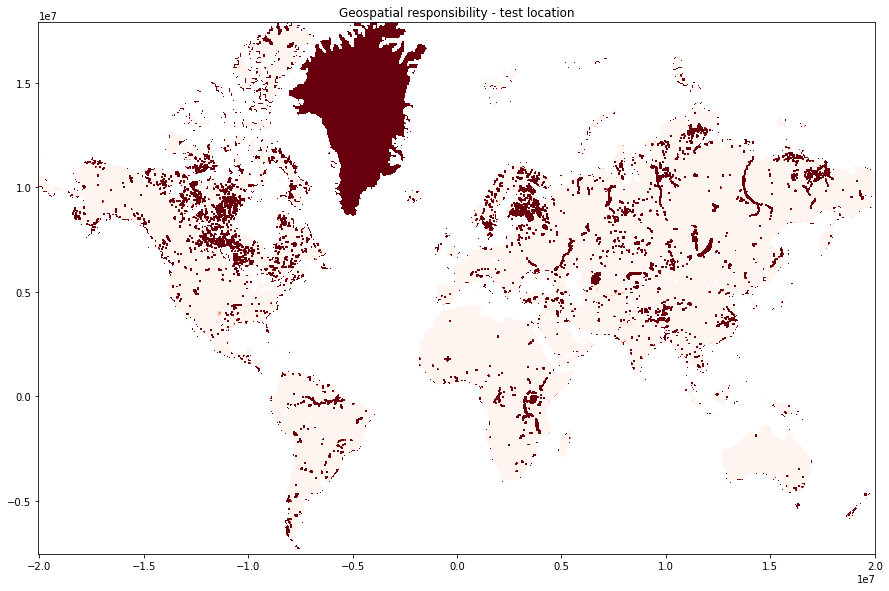

In [126]:
with rio.open("../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v3.tif") as src:
    image_array = src.read(1)
    msk = src.read_masks()
    fig, ax = plt.subplots(figsize=[15, 10])
    rio.plot.show(
        image_array,
        vmin=4.4836601744862e-05,
        vmax=0.14,
        cmap="Reds",
        ax=ax,
        transform=src.transform,
    )
    ax.set_title("Geospatial responsibility - test location")

    # the dark red shows no data

<a id='water_impact'></a>
### 3. Calculate water impact

    
    Unsustainable water consumption (m3 / year) = water risk (m3/year) *  probability purchase area (unitless) 

The datasets that we will need are:

In [129]:
water_risk = "../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v3.tif"
probability_area = (
    "../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif"
)

In [130]:
!gdalinfo $probability_area

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif
       ../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857.tif.aux.xml
Size is 3325, 36024
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisa

In [131]:
# put the two rasters into the same extent
## projwin: upper left and lower right of the raster that we want to use  for clipping the other rasters
## -of GTiff: geotiff we want to clip - change extent
!gdal_translate -projwin -20037507.1879 17903109.436 20032503.9216 -7536828.4444 -of GTiff $probability_area '../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857_new_extent.tif'

Input file size is 3325, 36024
0...10...20...30...40...50...60...70...80...90...100 - done.


In [132]:
!gdal_calc.py -A $water_risk -B '../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857_new_extent.tif'  --outfile='../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif' --calc="A*B"

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11

In [133]:
!gdalinfo -stats -hist '../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif
       ../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif.aux.xml
Size is 3325, 2111
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualis

  295 6 2 5 2 3 2 1 0 3 0 1 1 1 3 0 0 2 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



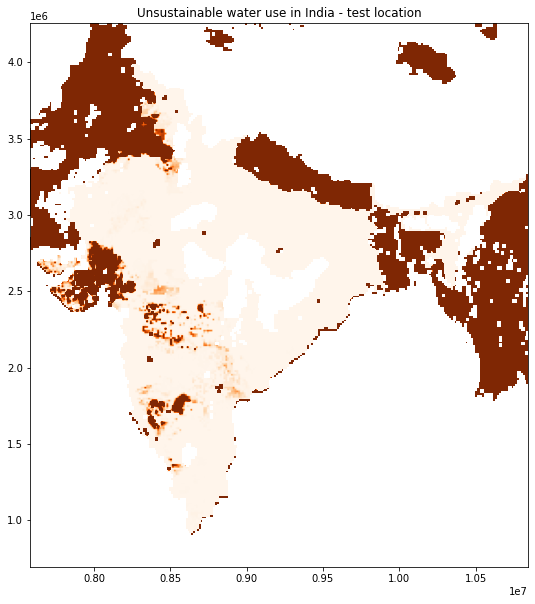

In [134]:
# check calculated risk map
with rio.open(
    "../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif"
) as src:
    dat = src.read(1)
    fig, ax = plt.subplots(figsize=[15, 10])
    ax.set_ylim((695174.093781, 4.255931e06))
    ax.set_xlim((7.582124e06, 1.084202e07))
    rio.plot.show(
        dat, vmin=0, vmax=7.9023620167261e-09, cmap="Oranges", ax=ax, transform=src.transform
    )
    # gdf_india.plot(ax=ax, alpha=0.5, color='Orange', edgecolor='yellow')
    ax.set_title("Unsustainable water use in India - test location")

    # dark red shows no data values

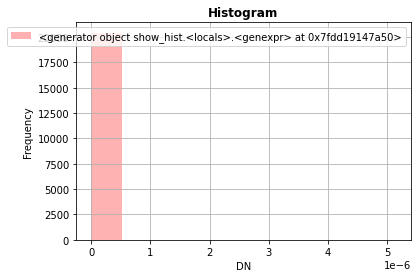

In [135]:
from rasterio.plot import show_hist

with rio.open(
    "../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif"
) as src:
    dat = src.read(1)
    show_hist(
        src, bins=10, lw=0, stacked=False, alpha=0.3, histtype="stepfilled", title="Histogram"
    )

In [148]:
test_location = gpd.read_file("../../datasets/raw/probability_map/test_location_epsg3857.shp")
test_location

,Material,Material d,Volume,Country,Address,Latitude,Longitude,Location t,Accuracy,Total_af,geometry
0,Cotton,None,745,India,None,None,None,Unknown,Low,8.357057e+10,"MULTIPOLYGON (((7582123.994 2704917.800, 75847..."


<a id='reproject_water_risk'></a>
### 4. Reproject water risk

I would like to explore the difference in results obtained by reprojecting the individual layers (previous work) vs reprojecting the final water risk map.

#### 4.1 Calculate water risk

Calculate water risk with datasets in the current projection(epsg4326):

    Water risk  (m3 / year ) =  blue water footprint (mm / yr) * harvest area portion in that location  * 1/1000(unit conversion)

In [140]:
!!gdalinfo '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif'

['Driver: GTiff/GeoTIFF',
 'Files: ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif',
 '       ../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif.aux.xml',
 'Size is 4320, 2160',
 'Coordinate System is:',
 'GEOGCRS["WGS 84",',
 '    DATUM["World Geodetic System 1984",',
 '        ELLIPSOID["WGS 84",6378137,298.257223563,',
 '            LENGTHUNIT["metre",1]]],',
 '    PRIMEM["Greenwich",0,',
 '        ANGLEUNIT["degree",0.0174532925199433]],',
 '    CS[ellipsoidal,2],',
 '        AXIS["geodetic latitude (Lat)",north,',
 '            ORDER[1],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '        AXIS["geodetic longitude (Lon)",east,',
 '            ORDER[2],',
 '            ANGLEUNIT["degree",0.0174532925199433]],',
 '    ID["EPSG",4326]]',
 'Data axis to CRS axis mapping: 2,1',
 'Origin = (-180.000000000000000,89.999999999989768)',
 'Pixel Size = (0.083333333333329,-0.083333333333329)',
 'Metadata:',
 '  AREA_OR_POINT=Area',
 '  TIFFTAG_SOFTWARE

In [141]:
!gdalinfo '../../datasets/raw/water_indicators/wfbl_mmyr_4326_cotton.tif'

Driver: GTiff/GeoTIFF
Files: ../../datasets/raw/water_indicators/wfbl_mmyr_4326_cotton.tif
Size is 4320, 1668
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-179.991666650000013,83.088333349999999)
Pixel Size = (0.083333333333333,-0.083333333333333)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-179.9916667,  83.0883333) (179d59'30.00"W, 83d 5'18.00"N)
Lower Left  (-179.9916667, -55.9116667) (179d59'30.00"W, 

In [142]:
# put the two rasters into the same extent
## projwin: upper left and lower right of the raster that we want to use  for clipping the other rasters
## -of GTiff: geotiff we want to clip - change extent
!gdal_translate -projwin -179.9916667  83.0883333 180.0083333 -55.9116667 -of GTiff '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction.tif' '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_new_extent.tif'

Input file size is 4320, 2160
0...10...20...30...40...50...60...70...80...90...100 - done.


In [144]:
!gdal_calc.py -A '../../datasets/raw/water_indicators/wfbl_mmyr_4326_cotton.tif' -B '../../datasets/raw/crop_data/cotton_HarvestedAreaFraction_new_extent.tif'  --outfile='../../datasets/processed/water_indicators/water_risk_cotton_epsg4326.tif' --calc="A*B*(1/1000)"

0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 12.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13.. 13

In [145]:
## reproject raster to epsg3857
# reproject the blue water footprint from epsg4326 to epsg3857
!gdalwarp -s_srs EPSG:4326 -t_srs EPSG:3857 -tr 12051.131160772875 12051.131160772875 -r near -of GTiff '../../datasets/processed/water_indicators/water_risk_cotton_epsg4326.tif' '../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v4.tif'

Creating output file that is 3325P x 2111L.
Processing ../../datasets/processed/water_indicators/water_risk_cotton_epsg4326.tif [1/1] : 0Using internal nodata values (e.g. 3.40282e+38) for image ../../datasets/processed/water_indicators/water_risk_cotton_epsg4326.tif.
Copying nodata values from source ../../datasets/processed/water_indicators/water_risk_cotton_epsg4326.tif to destination ../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v4.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


![alt text](../../datasets/processed/water_indicators/water_reprojections.png "Title")

In [147]:
## calculate matric using new reprojected layer
!gdal_calc.py -A '../../datasets/processed/water_indicators/water_risk_cotton_epsg3857_v4.tif' -B '../../datasets/processed/probability_map/purchase_area_distribution_cotton_epsg3857_new_extent.tif'  --outfile='../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857_v2.tif' --calc="A*B"

<string>:1: RuntimeWarning: overflow encountered in multiply
/opt/conda/lib/python3.8/site-packages/osgeo/utils/gdal_calc.py:367: RuntimeWarning: invalid value encountered in multiply
  myResult = ((1 * (myNDVs == 0)) * myResult) + (myOutNDV * myNDVs)


0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 0.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 1.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 2.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 3.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 4.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 5.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 6.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 7.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 8.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 9.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 10.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11.. 11

In [151]:
## calculate zonal statistics in test location
water_metric_v1 = (
    "../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857.tif"
)
water_metric_v2 = (
    "../../datasets/processed/water_indicators/water_impact_cotton_test_location_epsg3857_v2.tif"
)

start_time = time.time()
zs_india_test_v1 = zonal_stats(test_location, water_metric_v1, stats="sum")
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.24795866012573242 seconds ---


/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
print(" water impact v1:", {zs_india_test[0]["sum"]}, "m2")

In [152]:
start_time = time.time()
zs_india_test_v2 = zonal_stats(test_location, water_metric_v2, stats="sum")
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.192793607711792 seconds ---


<a id='finalNotes'></a>
### 4. Final notes

Based on the calculations done above:

- The reprojection of the blue water footprint gives weir results - something to check

- make more research on the reprojections. For now we can work with the reprojection of the water risk instead of the individual layers.
